In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm 
import pylab as py 
import datetime
import matplotlib as mpl
import seaborn as sns
from pandas.api.types import CategoricalDtype
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from time import time
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

datasetDL = pd.read_csv("serie-storiche-ecommerce.csv", sep =",")
pd.set_option('display.max_rows', None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# PRE-PROCESSING

In [ ]:
datasetDL.index.name = "data"
#print(datasetDL.index.name)
datasetDL["totale"] = datasetDL["data"] + "." + datasetDL["totale"] #unione delle colonne in quanto l'import del dataset riscontra dei problemi 
datasetDL["totale"]= datasetDL["totale"].str.replace("'","")
datasetDL=datasetDL.drop(columns="data")
#display(datasetDL)

In [ ]:
x = datasetDL["settore"].unique() #inserimento nell'array dei possibili settori
x=x.tolist() #trasformazione da array a lista
index=15 #in posizione 15 c'è il valore Nan che deve essere eliminato
x.pop(index) #viene eliminato il valore Nan 
#print(x)

#ciclo per sistemare i valori che contengono Nan andando ad inserire il Settore e il Totale corretto 
for index, row in datasetDL.iterrows():
    if (row['settore'] not in x):
            row['settore'] = row['totale'].split('.')[1]
            row['totale'] = row['totale'].split('.')[0]
datasetDL["totale"]=datasetDL["totale"].astype(float)
datasetDL = datasetDL.reset_index()
#display(datasetDL) 

In [ ]:
dataCasual = datasetDL[datasetDL['settore'] == "Casual"]

In [ ]:
dataRt1 = pd.read_csv('iss_rt_italia.csv', sep = ",")
#dataRt1 = dataRt1.iloc[268:350]
dataRt1 = dataRt1.drop(columns=['rt_positivi_err68perc', 'rt_sintomatici', 'rt_sintomatici_err68perc'])
dataRt1 = dataRt1.set_index('data')
dataRt1.index = pd.to_datetime(dataRt1.index)
# dataRt1

# dataRt1Week = dataRt1
# dataRt1Week = dataRt1Week.groupby(pd.Grouper(freq='W-MON')).last()
# print(dataRt1Week)

In [ ]:
dataCasual = dataCasual.reset_index()
dataCasual = dataCasual.drop(columns =['index', 'settore'])
# print(dataCasual)

In [ ]:
#cambiato il valore della riga con index 2316 (2020-07-31, -2159.18) perchè negativo
#sostituito in modo da non avere problemi nell'analisi della stagionalità
dataCasual.loc[2316,['totale']] = 0.1

In [ ]:
dataCasual = dataCasual.set_index('data')
dataCasual.index = pd.to_datetime(dataCasual.index)
# print(dataCasual)

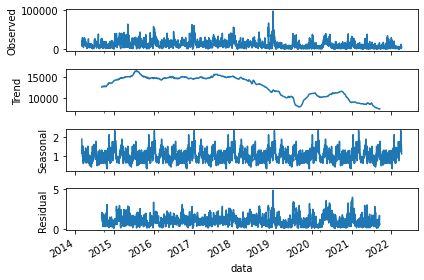

In [ ]:
# Error/Trend/Seasonality Models
N = 38
dataCasual2 = dataCasual.iloc[N:]
# print(dataCasual2)
# dataCasual2 = dataCasual2.drop(columns = ['year', 'month'])
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(dataCasual2['totale'], model='multiplicative', freq=365)  # model='mul' also works
result.plot();

Stazionarietà del dataset -- AGGIUNGERE TEST COERENTE CON QUELLO DI AUTO ARIMA (ovvero kpss)

SEASONALITY --> fare test ocsb

In [ ]:
# import pmdarima
# result = OCSBTest(dataCasual['totale'].dropna(), 365)
# print(result)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test(dataCasual['totale'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.811776e+00
p-value                 5.632087e-17
# lags used             7.000000e+00
# observations          2.893000e+03
critical value (1%)    -3.432612e+00
critical value (5%)    -2.862540e+00
critical value (10%)   -2.567302e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


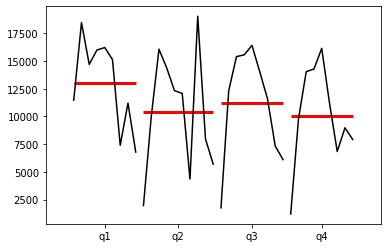

In [ ]:
from statsmodels.graphics.tsaplots import quarter_plot
dfq = dataCasual['totale'].resample(rule='Q').mean()

quarter_plot(dfq);

In [ ]:
dataCasual=dataCasual.reset_index()
# print(dataCasual)

# PROPHET

In [ ]:
from fbprophet import Prophet
import holidays

dataCasual.columns = ['ds','y']
dataCasual['ds'] = pd.to_datetime(dataCasual['ds'])

In [ ]:
train = dataCasual.iloc[:2816]
test = dataCasual.iloc[-2816:]

In [ ]:
from statsmodels.tools.eval_measures import rmse


import warnings
warnings.filterwarnings("ignore")

def rollingDaysProphet(data, train_end, window, iter = 10):

  rmseList = list()
  

  for i in range(iter):
    m = Prophet()
    train_data = data[:train_end]
    test_end = train_end + window
    test_data = data[train_end:test_end]
    train_end += 1

    m.fit(train_data)
    future = m.make_future_dataframe(periods=window,freq='D')
    forecast = m.predict(future)
    predictions = forecast.iloc[-window:]['yhat']

    print("predictions")
    print(predictions)

    print("test data")
    print(test_data['y'])

    # num = np.sum(np.square(test_data['y'] - predictions))
    # den = np.sum(np.square(predictions))
    # squared_error = num/den
    # rrmse_loss = np.sqrt(squared_error)
    EPSILON =  1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['y'] - predictions) / (test_data['y'] + EPSILON))))) * 100
    rmseList.append(rmspe)

  return rmseList

In [ ]:
train_end = 2816
rmseProphet = rollingDaysProphet(dataCasual,train_end, 1, 14)
print(rmseProphet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2816    17363.615829
Name: yhat, dtype: float64
test data
2816    7517.03
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2817    18453.357167
Name: yhat, dtype: float64
test data
2817    30026.91
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2818    21015.254127
Name: yhat, dtype: float64
test data
2818    20280.56
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2819    21138.205142
Name: yhat, dtype: float64
test data
2819    20090.9
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2820    20282.533267
Name: yhat, dtype: float64
test data
2820    24593.2
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2821    20862.181631
Name: yhat, dtype: float64
test data
2821    16706.67
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2822    20234.290212
Name: yhat, dtype: float64
test data
2822    18312.41
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2823    20300.721718
Name: yhat, dtype: float64
test data
2823    15883.6
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2824    20862.41887
Name: yhat, dtype: float64
test data
2824    14856.4
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2825    22292.399917
Name: yhat, dtype: float64
test data
2825    3641.3
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2826    21480.480243
Name: yhat, dtype: float64
test data
2826    18670.73
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2827    19720.511415
Name: yhat, dtype: float64
test data
2827    6912.56
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2828    19132.86194
Name: yhat, dtype: float64
test data
2828    8210.2
Name: y, dtype: float64
predictions
2829    17705.211749
Name: yhat, dtype: float64
test data
2829    15504.27
Name: y, dtype: float64
[130.99037557173557, 38.543935532454334, 3.6226520703016116, 5.212833382452357, 17.527880606463242, 24.873368728839914, 10.494960586904721, 27.809323563650658, 40.427148366128705, 512.209922742681, 15.04895760882514, 185.28521147790815, 133.0377084606855, 14.195713498070518]


In [ ]:
print(test)

             ds         y
85   2014-04-22  13675.84
86   2014-04-23   8644.65
87   2014-04-24   8044.82
88   2014-04-25   5851.52
89   2014-04-26   2165.46
90   2014-04-27   7169.08
91   2014-04-28   8855.06
92   2014-04-29   7859.79
93   2014-04-30  11451.84
94   2014-05-01   7203.20
95   2014-05-02   9536.22
96   2014-05-03   4989.70
97   2014-05-04   9346.55
98   2014-05-05  15388.83
99   2014-05-06  26716.91
100  2014-05-07   8728.71
101  2014-05-08  14526.47
102  2014-05-09   8818.76
103  2014-05-10  15003.50
104  2014-05-11  12496.09
105  2014-05-12  10036.17
106  2014-05-13  13974.94
107  2014-05-14   3708.17
108  2014-05-15  11364.10
109  2014-05-16   9340.00
110  2014-05-17  12587.79
111  2014-05-18  10732.61
112  2014-05-19   8780.83
113  2014-05-20   9993.05
114  2014-05-21   8461.54
115  2014-05-22  14200.90
116  2014-05-23  14380.74
117  2014-05-24  10526.30
118  2014-05-25   6230.85
119  2014-05-26   4740.14
120  2014-05-27   4966.23
121  2014-05-28  12961.39
122  2014-05

Prophet con variabile esogena relativa ai saldi

In [ ]:
# from fbprophet import Prophet
# import holidays

# dataCasual.columns = ['ds','y']
# dataCasual['ds'] = pd.to_datetime(dataCasual['ds'])

In [ ]:
# train = dataCasual.iloc[:2816]
# test = dataCasual.iloc[-2816:]

In [ ]:
saldiInv = pd.DataFrame({
  'holiday': 'saldiInv',
  'ds': pd.to_datetime(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13', '2014-01-14', '2014-01-15',
               '2014-01-16', '2014-01-17', '2014-01-18', '2014-01-19',
               '2014-01-20', '2014-01-21', '2014-01-22', '2014-01-23',
               '2014-01-24', '2014-01-25', '2014-01-26', '2014-01-27',
               '2014-01-28', '2014-01-29', '2014-01-30', '2014-01-31',
               '2014-02-01', '2014-02-02', '2014-02-03', '2014-02-04',
               '2014-02-05', '2014-02-06', '2014-02-07', '2014-02-08',
               '2014-02-09', '2014-02-10', '2014-02-11', '2014-02-12',
               '2014-02-13', '2014-02-14', '2014-02-15', '2014-02-16',
               '2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26', '2014-02-27', '2014-02-28',
               '2014-03-01', '2014-03-02', '2014-03-03', '2014-03-04',
               '2014-03-05', 
               '2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10',
               '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14',
               '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18',
               '2015-01-19', '2015-01-20', '2015-01-21', '2015-01-22',
               '2015-01-23', '2015-01-24', '2015-01-25', '2015-01-26',
               '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30',
               '2015-01-31', '2015-02-01', '2015-02-02', '2015-02-03',
               '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-07',
               '2015-02-08', '2015-02-09', '2015-02-10', '2015-02-11',
               '2015-02-12', '2015-02-13', '2015-02-14', '2015-02-15',
               '2015-02-16', '2015-02-17', '2015-02-18', '2015-02-19',
               '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23',
               '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27',
               '2015-02-28', '2015-03-01', '2015-03-02', '2015-03-03',
               '2015-03-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01',
               '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05',
               '2016-02-06', '2016-02-07', '2016-02-08', '2016-02-09',
               '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13',
               '2016-02-14', '2016-02-15', '2016-02-16', '2016-02-17',
               '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21',
               '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25',
               '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29',
               '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04',
               '2016-03-05',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
               '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
               '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
               '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
               '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
               '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
               '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
               '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
               '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
               '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
               '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
               '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
               '2017-03-02', '2017-03-03', '2017-03-04', '2017-03-05',             
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16',
               '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
               '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28',
               '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01',
               '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05',
               '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09',
               '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13',
               '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17',
               '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21',
               '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25',
               '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01',
               '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12',
               '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24',
               '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28',
               '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17',
               '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21',
               '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-25',
               '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01',
               '2019-03-02', '2019-03-03', '2019-03-04', '2019-03-05',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
               '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05'
              #  '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
              #  '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
              #  '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
              #  '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
              #  '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
              #  '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
              #  '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
              #  '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
              #  '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
              #  '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
              #  '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
              #  '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
              #  '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
              #  '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
              #  '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
              #  '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
              #  '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
              #  '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
              #  '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20',
              #  '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24',
              #  '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
              #  '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01',
              #  '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05',
              #  '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09',
              #  '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13',
              #  '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
              #  '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21',
              #  '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
              #  '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01',
              #  '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-05'
              ]),
  'lower_window': 0,
  'upper_window': 1,
})

saldiEstivi = pd.DataFrame({
  'holiday': 'saldiEstivi',
  'ds': pd.to_datetime(['2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10', '2014-07-11', '2014-07-12',
               '2014-07-13', '2014-07-14', '2014-07-15', '2014-07-16',
               '2014-07-17', '2014-07-18', '2014-07-19', '2014-07-20',
               '2014-07-21', '2014-07-22', '2014-07-23', '2014-07-24',
               '2014-07-25', '2014-07-26', '2014-07-27', '2014-07-28',
               '2014-07-29', '2014-07-30', '2014-07-31', '2014-08-01',
               '2014-08-02', '2014-08-03', '2014-08-04', '2014-08-05',
               '2014-08-06', '2014-08-07', '2014-08-08', '2014-08-09',
               '2014-08-10', '2014-08-11', '2014-08-12', '2014-08-13',
               '2014-08-14', '2014-08-15', '2014-08-16', '2014-08-17',
               '2014-08-18', '2014-08-19', '2014-08-20', '2014-08-21',
               '2014-08-22', '2014-08-23', '2014-08-24', '2014-08-25',
               '2014-08-26', '2014-08-27', '2014-08-28', '2014-08-29',
               '2014-08-30', '2014-08-31', '2014-09-01', '2014-09-02',
               '2014-09-03', 
               '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15',
               '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19',
               '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23',
               '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27',
               '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31',
               '2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04',
               '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08',
               '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12',
               '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
               '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20',
               '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
               '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
               '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01',
               '2015-09-02',
               '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05',
               '2016-07-06', '2016-07-07', '2016-07-08', '2016-07-09',
               '2016-07-10', '2016-07-11', '2016-07-12', '2016-07-13',
               '2016-07-14', '2016-07-15', '2016-07-16', '2016-07-17',
               '2016-07-18', '2016-07-19', '2016-07-20', '2016-07-21',
               '2016-07-22', '2016-07-23', '2016-07-24', '2016-07-25',
               '2016-07-26', '2016-07-27', '2016-07-28', '2016-07-29',
               '2016-07-30', '2016-07-31', '2016-08-01', '2016-08-02',
               '2016-08-03', '2016-08-04', '2016-08-05', '2016-08-06',
               '2016-08-07', '2016-08-08', '2016-08-09', '2016-08-10',
               '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
               '2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18',
               '2016-08-19', '2016-08-20', '2016-08-21', '2016-08-22',
               '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26',
               '2016-08-27', '2016-08-28', '2016-08-29', '2016-08-30',
               '2016-08-31',
               '2017-07-01', '2017-07-02', '2017-07-03', '2017-07-04',
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08',
               '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16',
               '2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
               '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30',
               '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10',
               '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14',
               '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18',
               '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22',
               '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26',
               '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30',
               '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03',
               '2018-08-04', '2018-08-05', '2018-08-06', '2018-08-07',
               '2018-08-08', '2018-08-09', '2018-08-10', '2018-08-11',
               '2018-08-12', '2018-08-13', '2018-08-14', '2018-08-15',
               '2018-08-16', '2018-08-17', '2018-08-18', '2018-08-19',
               '2018-08-20', '2018-08-21', '2018-08-22', '2018-08-23',
               '2018-08-24', '2018-08-25', '2018-08-26', '2018-08-27',
               '2018-08-28', '2018-08-29', '2018-08-30', '2018-08-31',
               '2018-09-01', '2018-09-02', '2018-09-03', '2018-09-04',
               '2018-09-05',
               '2019-07-06', '2019-07-07', '2019-07-08', '2019-07-09',
               '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13',
               '2019-07-14', '2019-07-15', '2019-07-16', '2019-07-17',
               '2019-07-18', '2019-07-19', '2019-07-20', '2019-07-21',
               '2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25',
               '2019-07-26', '2019-07-27', '2019-07-28', '2019-07-29',
               '2019-07-30', '2019-07-31', '2019-08-01', '2019-08-02',
               '2019-08-03', '2019-08-04', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08', '2019-08-09', '2019-08-10',
               '2019-08-11', '2019-08-12', '2019-08-13', '2019-08-14',
               '2019-08-15', '2019-08-16', '2019-08-17', '2019-08-18',
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-24', '2019-08-25', '2019-08-26',
               '2019-08-27', '2019-08-28', '2019-08-29', '2019-08-30',
               '2019-08-31', '2019-09-01', '2019-09-02', '2019-09-03',
               '2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
               '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
               '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
               '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
               '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01',
               '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30'
              #  '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06',
              #  '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10',
              #  '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14',
              #  '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
              #  '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
              #  '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
              #  '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
              #  '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
              #  '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
              #  '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11',
              #  '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15',
              #  '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19',
              #  '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23',
              #  '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27',
              #  '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31',
              #  '2021-09-01'
              ]),
  'lower_window': 0,
  'upper_window': 1,
})

saldiBFNat = pd.DataFrame({
  'holiday': 'saldiBFNat',
  'ds': pd.to_datetime(['2014-11-15', '2014-11-16', '2014-11-17', '2014-11-18',
               '2014-11-19', '2014-11-20', '2014-11-21', '2014-11-22',
               '2014-11-23', '2014-11-24', '2014-11-25', '2014-11-26',
               '2014-11-27', '2014-11-28', '2014-11-29', '2014-11-30',
               '2014-12-01', '2014-12-02', '2014-12-03', '2014-12-04',
               '2014-12-05', '2014-12-06', '2014-12-07', '2014-12-08',
               '2014-12-09', '2014-12-10', '2014-12-11', '2014-12-12',
               '2014-12-13', '2014-12-14', '2014-12-15',
               '2015-11-15', '2015-11-16', '2015-11-17', '2015-11-18',
               '2015-11-19', '2015-11-20', '2015-11-21', '2015-11-22',
               '2015-11-23', '2015-11-24', '2015-11-25', '2015-11-26',
               '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30',
               '2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04',
               '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08',
               '2015-12-09', '2015-12-10', '2015-12-11', '2015-12-12',
               '2015-12-13', '2015-12-14', '2015-12-15',
               '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
               '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22',
               '2016-11-23', '2016-11-24', '2016-11-25', '2016-11-26',
               '2016-11-27', '2016-11-28', '2016-11-29', '2016-11-30',
               '2016-12-01', '2016-12-02', '2016-12-03', '2016-12-04',
               '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
               '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14', '2016-12-15',
               '2017-11-15', '2017-11-16', '2017-11-17', '2017-11-18',
               '2017-11-19', '2017-11-20', '2017-11-21', '2017-11-22',
               '2017-11-23', '2017-11-24', '2017-11-25', '2017-11-26',
               '2017-11-27', '2017-11-28', '2017-11-29', '2017-11-30',
               '2017-12-01', '2017-12-02', '2017-12-03', '2017-12-04',
               '2017-12-05', '2017-12-06', '2017-12-07', '2017-12-08',
               '2017-12-09', '2017-12-10', '2017-12-11', '2017-12-12',
               '2017-12-13', '2017-12-14', '2017-12-15',
               '2018-11-15', '2018-11-16', '2018-11-17', '2018-11-18',
               '2018-11-19', '2018-11-20', '2018-11-21', '2018-11-22',
               '2018-11-23', '2018-11-24', '2018-11-25', '2018-11-26',
               '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30',
               '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04',
               '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08',
               '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12',
               '2018-12-13', '2018-12-14', '2018-12-15', 
               '2019-11-15', '2019-11-16', '2019-11-17', '2019-11-18',
               '2019-11-19', '2019-11-20', '2019-11-21', '2019-11-22',
               '2019-11-23', '2019-11-24', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-28', '2019-11-29', '2019-11-30',
               '2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06', '2019-12-07', '2019-12-08',
               '2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12',
               '2019-12-13', '2019-12-14', '2019-12-15',
               '2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15',
               '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
               '2021-11-19', '2021-11-20', '2021-11-21', '2021-11-22',
               '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
               '2021-12-13', '2021-12-14', '2021-12-15']),
  'lower_window': 0,
  'upper_window': 1,
})


holidays = pd.concat((saldiInv, saldiEstivi, saldiBFNat))

In [ ]:
from statsmodels.tools.eval_measures import rmse


import warnings
warnings.filterwarnings("ignore")

def rollingDaysProphetSaldi(data, train_end, window, iter = 10):

  rmseList = list()
  

  for i in range(iter):
    m = Prophet(holidays=holidays)
    train_data = data[:train_end]
    test_end = train_end + window
    test_data = data[train_end:test_end]
    train_end += 1
    
    m.fit(train_data)
    future = m.make_future_dataframe(periods=window,freq='D')
    forecast = m.predict(future)
    predictions = forecast.iloc[-window:]['yhat']

    print("predictions")
    print(predictions)

    print("test data")
    print(test_data['y'])

    EPSILON =  1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['y'] - predictions) / (test_data['y'] + EPSILON))))) * 100
    rmseList.append(rmspe)

  return rmseList

In [ ]:
train_end = 2816
rmsePrSaldi = rollingDaysProphetSaldi(dataCasual,train_end, 1, 14)
print(rmsePrSaldi)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2816    18014.514858
Name: yhat, dtype: float64
test data
2816    7517.03
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2817    19141.620385
Name: yhat, dtype: float64
test data
2817    30026.91
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2818    21494.439577
Name: yhat, dtype: float64
test data
2818    20280.56
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2819    21462.028726
Name: yhat, dtype: float64
test data
2819    20090.9
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2820    20538.344685
Name: yhat, dtype: float64
test data
2820    24593.2
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2821    21144.755693
Name: yhat, dtype: float64
test data
2821    16706.67
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2822    20277.604699
Name: yhat, dtype: float64
test data
2822    18312.41
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2823    20187.542048
Name: yhat, dtype: float64
test data
2823    15883.6
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2824    20597.227499
Name: yhat, dtype: float64
test data
2824    14856.4
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2825    21999.764542
Name: yhat, dtype: float64
test data
2825    3641.3
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2826    20983.245868
Name: yhat, dtype: float64
test data
2826    18670.73
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2827    19136.417003
Name: yhat, dtype: float64
test data
2827    6912.56
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2828    18531.814558
Name: yhat, dtype: float64
test data
2828    8210.2
Name: y, dtype: float64
predictions
2829    16923.509611
Name: yhat, dtype: float64
test data
2829    15504.27
Name: y, dtype: float64
[139.6493676042654, 36.25178086829052, 5.985434214267773, 6.824625706688386, 16.487709265267426, 26.564753438474558, 10.731491369362843, 27.09676678025041, 38.64211719603974, 504.173359569596, 12.385781745695933, 176.83545608363602, 125.71696862632432, 9.15386284238162]


Prophet con 2 variabili esogene: saldi e lockdown 

In [ ]:
# from fbprophet import Prophet
# import holidays

# dataCasual.columns = ['ds','y']
# dataCasual['ds'] = pd.to_datetime(dataCasual['ds'])

In [ ]:
# train = dataCasual.iloc[:2816]
# test = dataCasual.iloc[-2816:]

In [ ]:
saldiInv = pd.DataFrame({
  'holiday': 'saldiInv',
  'ds': pd.to_datetime(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13', '2014-01-14', '2014-01-15',
               '2014-01-16', '2014-01-17', '2014-01-18', '2014-01-19',
               '2014-01-20', '2014-01-21', '2014-01-22', '2014-01-23',
               '2014-01-24', '2014-01-25', '2014-01-26', '2014-01-27',
               '2014-01-28', '2014-01-29', '2014-01-30', '2014-01-31',
               '2014-02-01', '2014-02-02', '2014-02-03', '2014-02-04',
               '2014-02-05', '2014-02-06', '2014-02-07', '2014-02-08',
               '2014-02-09', '2014-02-10', '2014-02-11', '2014-02-12',
               '2014-02-13', '2014-02-14', '2014-02-15', '2014-02-16',
               '2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26', '2014-02-27', '2014-02-28',
               '2014-03-01', '2014-03-02', '2014-03-03', '2014-03-04',
               '2014-03-05', 
               '2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10',
               '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14',
               '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18',
               '2015-01-19', '2015-01-20', '2015-01-21', '2015-01-22',
               '2015-01-23', '2015-01-24', '2015-01-25', '2015-01-26',
               '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30',
               '2015-01-31', '2015-02-01', '2015-02-02', '2015-02-03',
               '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-07',
               '2015-02-08', '2015-02-09', '2015-02-10', '2015-02-11',
               '2015-02-12', '2015-02-13', '2015-02-14', '2015-02-15',
               '2015-02-16', '2015-02-17', '2015-02-18', '2015-02-19',
               '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23',
               '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27',
               '2015-02-28', '2015-03-01', '2015-03-02', '2015-03-03',
               '2015-03-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01',
               '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05',
               '2016-02-06', '2016-02-07', '2016-02-08', '2016-02-09',
               '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13',
               '2016-02-14', '2016-02-15', '2016-02-16', '2016-02-17',
               '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21',
               '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25',
               '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29',
               '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04',
               '2016-03-05',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
               '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
               '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
               '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
               '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
               '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
               '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
               '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
               '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
               '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
               '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
               '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
               '2017-03-02', '2017-03-03', '2017-03-04', '2017-03-05',             
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16',
               '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
               '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28',
               '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01',
               '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05',
               '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09',
               '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13',
               '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17',
               '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21',
               '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25',
               '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01',
               '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12',
               '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24',
               '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28',
               '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17',
               '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21',
               '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-25',
               '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01',
               '2019-03-02', '2019-03-03', '2019-03-04', '2019-03-05',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
               '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05'
              #  '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
              #  '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
              #  '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
              #  '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
              #  '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
              #  '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
              #  '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
              #  '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
              #  '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
              #  '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
              #  '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
              #  '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
              #  '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
              #  '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
              #  '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
              #  '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
              #  '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
              #  '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
              #  '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20',
              #  '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24',
              #  '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
              #  '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01',
              #  '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05',
              #  '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09',
              #  '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13',
              #  '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
              #  '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21',
              #  '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
              #  '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01',
              #  '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-05'
              ]),
  'lower_window': 0,
  'upper_window': 1,
})

saldiEstivi = pd.DataFrame({
  'holiday': 'saldiEstivi',
  'ds': pd.to_datetime(['2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10', '2014-07-11', '2014-07-12',
               '2014-07-13', '2014-07-14', '2014-07-15', '2014-07-16',
               '2014-07-17', '2014-07-18', '2014-07-19', '2014-07-20',
               '2014-07-21', '2014-07-22', '2014-07-23', '2014-07-24',
               '2014-07-25', '2014-07-26', '2014-07-27', '2014-07-28',
               '2014-07-29', '2014-07-30', '2014-07-31', '2014-08-01',
               '2014-08-02', '2014-08-03', '2014-08-04', '2014-08-05',
               '2014-08-06', '2014-08-07', '2014-08-08', '2014-08-09',
               '2014-08-10', '2014-08-11', '2014-08-12', '2014-08-13',
               '2014-08-14', '2014-08-15', '2014-08-16', '2014-08-17',
               '2014-08-18', '2014-08-19', '2014-08-20', '2014-08-21',
               '2014-08-22', '2014-08-23', '2014-08-24', '2014-08-25',
               '2014-08-26', '2014-08-27', '2014-08-28', '2014-08-29',
               '2014-08-30', '2014-08-31', '2014-09-01', '2014-09-02',
               '2014-09-03', 
               '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15',
               '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19',
               '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23',
               '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27',
               '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31',
               '2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04',
               '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08',
               '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12',
               '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
               '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20',
               '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
               '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
               '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01',
               '2015-09-02',
               '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05',
               '2016-07-06', '2016-07-07', '2016-07-08', '2016-07-09',
               '2016-07-10', '2016-07-11', '2016-07-12', '2016-07-13',
               '2016-07-14', '2016-07-15', '2016-07-16', '2016-07-17',
               '2016-07-18', '2016-07-19', '2016-07-20', '2016-07-21',
               '2016-07-22', '2016-07-23', '2016-07-24', '2016-07-25',
               '2016-07-26', '2016-07-27', '2016-07-28', '2016-07-29',
               '2016-07-30', '2016-07-31', '2016-08-01', '2016-08-02',
               '2016-08-03', '2016-08-04', '2016-08-05', '2016-08-06',
               '2016-08-07', '2016-08-08', '2016-08-09', '2016-08-10',
               '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
               '2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18',
               '2016-08-19', '2016-08-20', '2016-08-21', '2016-08-22',
               '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26',
               '2016-08-27', '2016-08-28', '2016-08-29', '2016-08-30',
               '2016-08-31',
               '2017-07-01', '2017-07-02', '2017-07-03', '2017-07-04',
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08',
               '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16',
               '2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
               '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30',
               '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10',
               '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14',
               '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18',
               '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22',
               '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26',
               '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30',
               '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03',
               '2018-08-04', '2018-08-05', '2018-08-06', '2018-08-07',
               '2018-08-08', '2018-08-09', '2018-08-10', '2018-08-11',
               '2018-08-12', '2018-08-13', '2018-08-14', '2018-08-15',
               '2018-08-16', '2018-08-17', '2018-08-18', '2018-08-19',
               '2018-08-20', '2018-08-21', '2018-08-22', '2018-08-23',
               '2018-08-24', '2018-08-25', '2018-08-26', '2018-08-27',
               '2018-08-28', '2018-08-29', '2018-08-30', '2018-08-31',
               '2018-09-01', '2018-09-02', '2018-09-03', '2018-09-04',
               '2018-09-05',
               '2019-07-06', '2019-07-07', '2019-07-08', '2019-07-09',
               '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13',
               '2019-07-14', '2019-07-15', '2019-07-16', '2019-07-17',
               '2019-07-18', '2019-07-19', '2019-07-20', '2019-07-21',
               '2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25',
               '2019-07-26', '2019-07-27', '2019-07-28', '2019-07-29',
               '2019-07-30', '2019-07-31', '2019-08-01', '2019-08-02',
               '2019-08-03', '2019-08-04', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08', '2019-08-09', '2019-08-10',
               '2019-08-11', '2019-08-12', '2019-08-13', '2019-08-14',
               '2019-08-15', '2019-08-16', '2019-08-17', '2019-08-18',
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-24', '2019-08-25', '2019-08-26',
               '2019-08-27', '2019-08-28', '2019-08-29', '2019-08-30',
               '2019-08-31', '2019-09-01', '2019-09-02', '2019-09-03',
               '2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
               '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
               '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
               '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
               '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01',
               '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30'
              #  '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06',
              #  '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10',
              #  '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14',
              #  '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
              #  '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
              #  '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
              #  '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
              #  '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
              #  '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
              #  '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11',
              #  '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15',
              #  '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19',
              #  '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23',
              #  '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27',
              #  '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31',
              #  '2021-09-01'
              ]),
  'lower_window': 0,
  'upper_window': 1,
})

saldiBFNat = pd.DataFrame({
  'holiday': 'saldiBFNat',
  'ds': pd.to_datetime(['2014-11-15', '2014-11-16', '2014-11-17', '2014-11-18',
               '2014-11-19', '2014-11-20', '2014-11-21', '2014-11-22',
               '2014-11-23', '2014-11-24', '2014-11-25', '2014-11-26',
               '2014-11-27', '2014-11-28', '2014-11-29', '2014-11-30',
               '2014-12-01', '2014-12-02', '2014-12-03', '2014-12-04',
               '2014-12-05', '2014-12-06', '2014-12-07', '2014-12-08',
               '2014-12-09', '2014-12-10', '2014-12-11', '2014-12-12',
               '2014-12-13', '2014-12-14', '2014-12-15',
               '2015-11-15', '2015-11-16', '2015-11-17', '2015-11-18',
               '2015-11-19', '2015-11-20', '2015-11-21', '2015-11-22',
               '2015-11-23', '2015-11-24', '2015-11-25', '2015-11-26',
               '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30',
               '2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04',
               '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08',
               '2015-12-09', '2015-12-10', '2015-12-11', '2015-12-12',
               '2015-12-13', '2015-12-14', '2015-12-15',
               '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
               '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22',
               '2016-11-23', '2016-11-24', '2016-11-25', '2016-11-26',
               '2016-11-27', '2016-11-28', '2016-11-29', '2016-11-30',
               '2016-12-01', '2016-12-02', '2016-12-03', '2016-12-04',
               '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
               '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14', '2016-12-15',
               '2017-11-15', '2017-11-16', '2017-11-17', '2017-11-18',
               '2017-11-19', '2017-11-20', '2017-11-21', '2017-11-22',
               '2017-11-23', '2017-11-24', '2017-11-25', '2017-11-26',
               '2017-11-27', '2017-11-28', '2017-11-29', '2017-11-30',
               '2017-12-01', '2017-12-02', '2017-12-03', '2017-12-04',
               '2017-12-05', '2017-12-06', '2017-12-07', '2017-12-08',
               '2017-12-09', '2017-12-10', '2017-12-11', '2017-12-12',
               '2017-12-13', '2017-12-14', '2017-12-15',
               '2018-11-15', '2018-11-16', '2018-11-17', '2018-11-18',
               '2018-11-19', '2018-11-20', '2018-11-21', '2018-11-22',
               '2018-11-23', '2018-11-24', '2018-11-25', '2018-11-26',
               '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30',
               '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04',
               '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08',
               '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12',
               '2018-12-13', '2018-12-14', '2018-12-15', 
               '2019-11-15', '2019-11-16', '2019-11-17', '2019-11-18',
               '2019-11-19', '2019-11-20', '2019-11-21', '2019-11-22',
               '2019-11-23', '2019-11-24', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-28', '2019-11-29', '2019-11-30',
               '2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06', '2019-12-07', '2019-12-08',
               '2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12',
               '2019-12-13', '2019-12-14', '2019-12-15',
               '2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15',
               '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
               '2021-11-19', '2021-11-20', '2021-11-21', '2021-11-22',
               '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
               '2021-12-13', '2021-12-14', '2021-12-15']),
  'lower_window': 0,
  'upper_window': 1,
})

lockdown = pd.DataFrame({
  'holiday': 'lockdown',
  'ds': pd.to_datetime(['2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
              '2020-03-16', '2020-03-17','2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22',
              '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
              '2020-03-30', '2020-03-31',
              '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
              '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12',
              '2020-04-13', '2020-04-14','2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
              '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
              '2020-04-27', '2020-04-28','2020-04-29', '2020-04-30',
              '2020-05-01', '2020-05-02','2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07',
              '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14',
             '2020-05-15','2020-05-16','2020-05-17','2020-05-18',

             #zona rossa
             '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07', 
             '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-14', '2020-11-15',
             '2020-11-16', '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23',
             '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',   

             '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', 
             '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12', '2020-12-13', '2020-12-14', '2020-12-15','2020-12-16', 
             '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24', 
             '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-30', '2020-12-31',

             '2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08', 
             '2021-01-09', '2021-01-10',
             '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14', '2021-03-15', '2021-03-16', '2021-03-17',
             '2021-03-18', '2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
             '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29', '2021-03-30', '2021-03-31', 
             '2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08', 
             '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16',
             '2021-04-17', '2021-04-18', '2021-04-19', '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24',
             '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30'
             ]),
  'lower_window': 0,
  'upper_window': 1,
})

holidaysCov = pd.concat((saldiInv, saldiEstivi, saldiBFNat, lockdown))

In [ ]:
from statsmodels.tools.eval_measures import rmse


import warnings
warnings.filterwarnings("ignore")

def rollingDaysProphetCov(data, train_end, window, iter = 10):

  rmseList = list()
  

  for i in range(iter):
    m = Prophet(holidays=holidaysCov)
    train_data = data[:train_end]
    test_end = train_end + window
    test_data = data[train_end:test_end]
    train_end += 1
    
    m.fit(train_data)
    future = m.make_future_dataframe(periods=window,freq='D')
    forecast = m.predict(future)
    predictions = forecast.iloc[-window:]['yhat']
    
    print("predictions")
    print(predictions)

    print("test data")
    print(test_data['y'])

    EPSILON =  1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['y'] - predictions) / (test_data['y'] + EPSILON))))) * 100
    rmseList.append(rmspe)

  return rmseList

In [ ]:
train_end = 2816
rmsePrCovid = rollingDaysProphetCov(dataCasual,train_end, 1, 14)
print(rmsePrCovid)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2816    17121.793012
Name: yhat, dtype: float64
test data
2816    7517.03
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2817    18179.84555
Name: yhat, dtype: float64
test data
2817    30026.91
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2818    20535.78871
Name: yhat, dtype: float64
test data
2818    20280.56
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2819    20711.114016
Name: yhat, dtype: float64
test data
2819    20090.9
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2820    19731.405736
Name: yhat, dtype: float64
test data
2820    24593.2
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2821    20326.799674
Name: yhat, dtype: float64
test data
2821    16706.67
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2822    19564.730759
Name: yhat, dtype: float64
test data
2822    18312.41
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2823    19636.177396
Name: yhat, dtype: float64
test data
2823    15883.6
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2824    20051.113583
Name: yhat, dtype: float64
test data
2824    14856.4
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2825    21357.904004
Name: yhat, dtype: float64
test data
2825    3641.3
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2826    20453.730479
Name: yhat, dtype: float64
test data
2826    18670.73
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2827    18682.168473
Name: yhat, dtype: float64
test data
2827    6912.56
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2828    18088.203677
Name: yhat, dtype: float64
test data
2828    8210.2
Name: y, dtype: float64
predictions
2829    16519.793649
Name: yhat, dtype: float64
test data
2829    15504.27
Name: y, dtype: float64
[127.77337608080168, 39.45482385489662, 1.2584894580807435, 3.0870394835977217, 19.768855879914806, 21.668768666093165, 6.838645261214375, 23.62548412352013, 34.966166656434126, 486.546123747865, 9.54970951075017, 170.26410581848137, 120.31380084075047, 6.549961065871006]


# ARIMA

### Import pacchetti /// preprocessing sul dataset dedicato ad ARIMA

In [ ]:
datasetAR = pd.read_csv("serie-storiche-ecommerce-ARIMA.csv", sep =",")
pd.set_option('display.max_rows', None)

In [ ]:
!pip install pmdarima
from pmdarima import auto_arima # for determining ARIMA orders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 4.9 MB/s 
     |████████████████████████████████| 9.8 MB 34.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
datasetAR.index.name = "data"
#print(datasetAR.index.name)
datasetAR["totale"] = datasetAR["data"] + "." + datasetAR["totale"] #unione delle colonne in quanto l'import del dataset riscontra dei problemi 
datasetAR["totale"]= datasetAR["totale"].str.replace("'","")
datasetAR=datasetAR.drop(columns="data")
#display(datasetAR)

In [ ]:
x = datasetAR["settore"].unique() #inserimento nell'array dei possibili settori
x=x.tolist() #trasformazione da array a lista
index=15 #in posizione 15 c'è il valore Nan che deve essere eliminato
x.pop(index) #viene eliminato il valore Nan 
#print(x)

#ciclo per sistemare i valori che contengono Nan andando ad inserire il Settore e il Totale corretto 
for index, row in datasetAR.iterrows():
    if (row['settore'] not in x):
            row['settore'] = row['totale'].split('.')[1]
            row['totale'] = row['totale'].split('.')[0]
datasetAR["totale"]=datasetAR["totale"].astype(float)
datasetAR = datasetAR.reset_index()
#display(datasetAR) 

In [ ]:
dataCasualAR = datasetAR[datasetAR['settore'] == "Casual"]

In [ ]:
!pip install cython
!pip install pmdarima
!pip install cuda-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.4 MB 309 kB/s 


In [ ]:
dataCasualAR = dataCasualAR.set_index('data')
dataCasualAR.index = pd.to_datetime(dataCasualAR.index)

### ARIMA con Fourier

In [ ]:
from statsmodels.tools.eval_measures import rmse
from pmdarima.preprocessing import FourierFeaturizer

import warnings
warnings.filterwarnings("ignore")

def rollingDaysFourier(data, train_end, window, iter = 10):

  rmseList = list()
  
  train_data = data[:train_end]
  
  trans = FourierFeaturizer(365, 6)
  y_prime, X = trans.fit_transform(data)
  
  X['date'] = y_prime.index
  X = X.set_index('date')

  X_train = X[:train_end]
  
  stepwise_fit = auto_arima(train_data, seasonal=False, exogenous=X_train, error_action='ignore', suppress_warnings=True, trace =True)

  for i in range(iter):
    test_end = train_end+timedelta(days=window)
    test_data = data[train_end + timedelta(days=1):test_end]
    X_test = X[train_end + timedelta(days=1):test_end]
    train_end += timedelta(days=1)

    print(stepwise_fit.order)
    print(stepwise_fit.seasonal_order)
    # #model = SARIMAX(train_data, order=stepwise_fit.order, exog=X_train)
    # #fit the model
    # start = time()
    # #model_fit = stepwise_fit.fit()
    # end = time()
    # print('Model Fitting Time:', end - start)
    # #get the predictions and residuals
    predictions = stepwise_fit.predict(window, X=X_test)
    predictions = pd.DataFrame({'date':test_data.index[0] ,'totale':predictions})
    residuals = test_data.totale - predictions.totale
    predictions = predictions.set_index('date')
    # predictions.index = pd.to_datetime(predictions.index)
    # print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.totale)),4))
    # print('Root Mean Squared Error:', (rmse(test_data['totale'], predictions['totale'])))
    print('real value', test_data)
    print('predictions', predictions)
    
    EPSILON = 1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['totale'] - predictions['totale']) / (test_data['totale'] + EPSILON)), axis=0))) * 100
    print(rmspe)
    rmseList.append(rmspe)

  return rmseList

In [ ]:
dataCasualAR = dataCasualAR.drop(columns=['settore'])

In [ ]:
train_end = datetime(2021,12,31)
rmseARIMAFourier = rollingDaysFourier(dataCasualAR,train_end, 1, 14)
print(rmseARIMAFourier)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=58088.783, Time=3.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58980.731, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58477.742, Time=0.74 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=58153.100, Time=1.98 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=78523.482, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=14.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=58060.961, Time=4.79 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=58090.773, Time=3.45 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=58322.665, Time=1.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=14.33 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=58273.015, Time=1.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=58044.760, Time=11.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=58044.644, Time=14.93 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=16.77 sec
 ARIMA(5,1,2)(0,0,0)[0] intercep

### ARIMA

In [ ]:
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

def rollingDays(data, train_end, window, iter = 10):

  rmseList = list()
  
  train_data = data[:train_end]
  stepwise_fit = auto_arima(train_data, seasonal=False, error_action='ignore', suppress_warnings=True, trace =True)

  for i in range(iter):
    test_end = train_end+timedelta(days=window)
    test_data = data[train_end + timedelta(days=1):test_end]
    train_end += timedelta(days=1)

    # print(train_end)
    # print(test_end)

    print(stepwise_fit.order)
    print(stepwise_fit.seasonal_order)
    # model = SARIMAX(train_data, order=stepwise_fit.order, seasonal_order=stepwise_fit.seasonal_order)
    # fit modello
    # start = time()
    # model_fit = model.fit()
    # end = time()
    # print('Model Fitting Time:', end - start)
    #predictions e residuals
    predictions = stepwise_fit.predict(window)
    predictions = pd.DataFrame({'date':test_data.index[0] ,'totale':predictions})
    residuals = test_data.totale - predictions.totale
    predictions = predictions.set_index('date')
    # predictions.index = pd.to_datetime(predictions.index)
    # print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.totale)),4))
    # print('Root Mean Squared Error:', (rmse(test_data['totale'], predictions['totale'])))
    print('real value', test_data)
    print('predictions', predictions)
    
    EPSILON = 1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['totale'] - predictions['totale']) / (test_data['totale'] + EPSILON)), axis=0))) * 100
    print(rmspe)
    rmseList.append(rmspe)

  return rmseList

In [ ]:
train_end = datetime(2021,12,31)
rmseAR = rollingDays(dataCasualAR,train_end, 1, 14)
print(rmseAR)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=58091.153, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58957.859, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58456.283, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=58141.824, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58955.861, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=58073.541, Time=1.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=58091.875, Time=0.68 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=58302.759, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=58065.268, Time=1.73 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=58254.366, Time=0.36 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.61 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=58060.926, Time=3.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=58061.221, Time=4.48 sec
 ARIMA(3,1,3)(0,0,0)[0] interce

### ARIMA con variabile esognena SALDI

In [ ]:
import datetime

def asDate(stringa):
  today = datetime.datetime.strptime(stringa, "%Y-%m-%d")
  return today

listaInv = ['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13', '2014-01-14', '2014-01-15',
               '2014-01-16', '2014-01-17', '2014-01-18', '2014-01-19',
               '2014-01-20', '2014-01-21', '2014-01-22', '2014-01-23',
               '2014-01-24', '2014-01-25', '2014-01-26', '2014-01-27',
               '2014-01-28', '2014-01-29', '2014-01-30', '2014-01-31',
               '2014-02-01', '2014-02-02', '2014-02-03', '2014-02-04',
               '2014-02-05', '2014-02-06', '2014-02-07', '2014-02-08',
               '2014-02-09', '2014-02-10', '2014-02-11', '2014-02-12',
               '2014-02-13', '2014-02-14', '2014-02-15', '2014-02-16',
               '2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26', '2014-02-27', '2014-02-28',
               '2014-03-01', '2014-03-02', '2014-03-03', '2014-03-04',
               '2014-03-05', 
               '2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10',
               '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14',
               '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18',
               '2015-01-19', '2015-01-20', '2015-01-21', '2015-01-22',
               '2015-01-23', '2015-01-24', '2015-01-25', '2015-01-26',
               '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30',
               '2015-01-31', '2015-02-01', '2015-02-02', '2015-02-03',
               '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-07',
               '2015-02-08', '2015-02-09', '2015-02-10', '2015-02-11',
               '2015-02-12', '2015-02-13', '2015-02-14', '2015-02-15',
               '2015-02-16', '2015-02-17', '2015-02-18', '2015-02-19',
               '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23',
               '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27',
               '2015-02-28', '2015-03-01', '2015-03-02', '2015-03-03',
               '2015-03-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01',
               '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05',
               '2016-02-06', '2016-02-07', '2016-02-08', '2016-02-09',
               '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13',
               '2016-02-14', '2016-02-15', '2016-02-16', '2016-02-17',
               '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21',
               '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25',
               '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29',
               '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04',
               '2016-03-05',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
               '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
               '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
               '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
               '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
               '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
               '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
               '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
               '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
               '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
               '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
               '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
               '2017-03-02', '2017-03-03', '2017-03-04', '2017-03-05',             
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16',
               '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
               '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28',
               '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01',
               '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05',
               '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09',
               '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13',
               '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17',
               '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21',
               '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25',
               '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01',
               '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12',
               '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24',
               '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28',
               '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17',
               '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21',
               '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-25',
               '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01',
               '2019-03-02', '2019-03-03', '2019-03-04', '2019-03-05',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
               '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
               '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
               '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
               '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
               '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
               '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
               '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20',
               '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24',
               '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
               '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01',
               '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05',
               '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09',
               '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13',
               '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
               '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21',
               '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
               '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01',
               '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-05'
              ]

listaEst = ['2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10', '2014-07-11', '2014-07-12',
               '2014-07-13', '2014-07-14', '2014-07-15', '2014-07-16',
               '2014-07-17', '2014-07-18', '2014-07-19', '2014-07-20',
               '2014-07-21', '2014-07-22', '2014-07-23', '2014-07-24',
               '2014-07-25', '2014-07-26', '2014-07-27', '2014-07-28',
               '2014-07-29', '2014-07-30', '2014-07-31', '2014-08-01',
               '2014-08-02', '2014-08-03', '2014-08-04', '2014-08-05',
               '2014-08-06', '2014-08-07', '2014-08-08', '2014-08-09',
               '2014-08-10', '2014-08-11', '2014-08-12', '2014-08-13',
               '2014-08-14', '2014-08-15', '2014-08-16', '2014-08-17',
               '2014-08-18', '2014-08-19', '2014-08-20', '2014-08-21',
               '2014-08-22', '2014-08-23', '2014-08-24', '2014-08-25',
               '2014-08-26', '2014-08-27', '2014-08-28', '2014-08-29',
               '2014-08-30', '2014-08-31', '2014-09-01', '2014-09-02',
               '2014-09-03', 
               '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15',
               '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19',
               '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23',
               '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27',
               '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31',
               '2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04',
               '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08',
               '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12',
               '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
               '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20',
               '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
               '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
               '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01',
               '2015-09-02',
               '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05',
               '2016-07-06', '2016-07-07', '2016-07-08', '2016-07-09',
               '2016-07-10', '2016-07-11', '2016-07-12', '2016-07-13',
               '2016-07-14', '2016-07-15', '2016-07-16', '2016-07-17',
               '2016-07-18', '2016-07-19', '2016-07-20', '2016-07-21',
               '2016-07-22', '2016-07-23', '2016-07-24', '2016-07-25',
               '2016-07-26', '2016-07-27', '2016-07-28', '2016-07-29',
               '2016-07-30', '2016-07-31', '2016-08-01', '2016-08-02',
               '2016-08-03', '2016-08-04', '2016-08-05', '2016-08-06',
               '2016-08-07', '2016-08-08', '2016-08-09', '2016-08-10',
               '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
               '2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18',
               '2016-08-19', '2016-08-20', '2016-08-21', '2016-08-22',
               '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26',
               '2016-08-27', '2016-08-28', '2016-08-29', '2016-08-30',
               '2016-08-31',
               '2017-07-01', '2017-07-02', '2017-07-03', '2017-07-04',
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08',
               '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16',
               '2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
               '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30',
               '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10',
               '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14',
               '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18',
               '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22',
               '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26',
               '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30',
               '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03',
               '2018-08-04', '2018-08-05', '2018-08-06', '2018-08-07',
               '2018-08-08', '2018-08-09', '2018-08-10', '2018-08-11',
               '2018-08-12', '2018-08-13', '2018-08-14', '2018-08-15',
               '2018-08-16', '2018-08-17', '2018-08-18', '2018-08-19',
               '2018-08-20', '2018-08-21', '2018-08-22', '2018-08-23',
               '2018-08-24', '2018-08-25', '2018-08-26', '2018-08-27',
               '2018-08-28', '2018-08-29', '2018-08-30', '2018-08-31',
               '2018-09-01', '2018-09-02', '2018-09-03', '2018-09-04',
               '2018-09-05',
               '2019-07-06', '2019-07-07', '2019-07-08', '2019-07-09',
               '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13',
               '2019-07-14', '2019-07-15', '2019-07-16', '2019-07-17',
               '2019-07-18', '2019-07-19', '2019-07-20', '2019-07-21',
               '2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25',
               '2019-07-26', '2019-07-27', '2019-07-28', '2019-07-29',
               '2019-07-30', '2019-07-31', '2019-08-01', '2019-08-02',
               '2019-08-03', '2019-08-04', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08', '2019-08-09', '2019-08-10',
               '2019-08-11', '2019-08-12', '2019-08-13', '2019-08-14',
               '2019-08-15', '2019-08-16', '2019-08-17', '2019-08-18',
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-24', '2019-08-25', '2019-08-26',
               '2019-08-27', '2019-08-28', '2019-08-29', '2019-08-30',
               '2019-08-31', '2019-09-01', '2019-09-02', '2019-09-03',
               '2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
               '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
               '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
               '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
               '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01',
               '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30',
               '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06',
               '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10',
               '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
               '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
               '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
               '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
               '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15',
               '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19',
               '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23',
               '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27',
               '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31',
               '2021-09-01'
              ]
listaBFNat = ['2014-11-15', '2014-11-16', '2014-11-17', '2014-11-18',
               '2014-11-19', '2014-11-20', '2014-11-21', '2014-11-22',
               '2014-11-23', '2014-11-24', '2014-11-25', '2014-11-26',
               '2014-11-27', '2014-11-28', '2014-11-29', '2014-11-30',
               '2014-12-01', '2014-12-02', '2014-12-03', '2014-12-04',
               '2014-12-05', '2014-12-06', '2014-12-07', '2014-12-08',
               '2014-12-09', '2014-12-10', '2014-12-11', '2014-12-12',
               '2014-12-13', '2014-12-14', '2014-12-15',
               '2015-11-15', '2015-11-16', '2015-11-17', '2015-11-18',
               '2015-11-19', '2015-11-20', '2015-11-21', '2015-11-22',
               '2015-11-23', '2015-11-24', '2015-11-25', '2015-11-26',
               '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30',
               '2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04',
               '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08',
               '2015-12-09', '2015-12-10', '2015-12-11', '2015-12-12',
               '2015-12-13', '2015-12-14', '2015-12-15',
               '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
               '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22',
               '2016-11-23', '2016-11-24', '2016-11-25', '2016-11-26',
               '2016-11-27', '2016-11-28', '2016-11-29', '2016-11-30',
               '2016-12-01', '2016-12-02', '2016-12-03', '2016-12-04',
               '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
               '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14', '2016-12-15',
               '2017-11-15', '2017-11-16', '2017-11-17', '2017-11-18',
               '2017-11-19', '2017-11-20', '2017-11-21', '2017-11-22',
               '2017-11-23', '2017-11-24', '2017-11-25', '2017-11-26',
               '2017-11-27', '2017-11-28', '2017-11-29', '2017-11-30',
               '2017-12-01', '2017-12-02', '2017-12-03', '2017-12-04',
               '2017-12-05', '2017-12-06', '2017-12-07', '2017-12-08',
               '2017-12-09', '2017-12-10', '2017-12-11', '2017-12-12',
               '2017-12-13', '2017-12-14', '2017-12-15',
               '2018-11-15', '2018-11-16', '2018-11-17', '2018-11-18',
               '2018-11-19', '2018-11-20', '2018-11-21', '2018-11-22',
               '2018-11-23', '2018-11-24', '2018-11-25', '2018-11-26',
               '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30',
               '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04',
               '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08',
               '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12',
               '2018-12-13', '2018-12-14', '2018-12-15', 
               '2019-11-15', '2019-11-16', '2019-11-17', '2019-11-18',
               '2019-11-19', '2019-11-20', '2019-11-21', '2019-11-22',
               '2019-11-23', '2019-11-24', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-28', '2019-11-29', '2019-11-30',
               '2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06', '2019-12-07', '2019-12-08',
               '2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12',
               '2019-12-13', '2019-12-14', '2019-12-15',
               '2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15',
               '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
               '2021-11-19', '2021-11-20', '2021-11-21', '2021-11-22',
               '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
               '2021-12-13', '2021-12-14', '2021-12-15']

saldiInv = set([])
for i in listaInv:
  data = asDate(i)
  saldiInv.add(data)

saldiEst = set([])
for i in listaEst:
  data = asDate(i)
  saldiEst.add(data)

saldiBFNat = set([])
for i in listaBFNat:
  data = asDate(i)
  saldiBFNat.add(data) 

In [ ]:
saldiInvernali = []
for i in range(len(dataCasualAR)):
  count = list(saldiInv).count(dataCasualAR.index[i])
  if(count > 0):
    saldiInvernali.append(1)
  else: 
    saldiInvernali.append(0)

dataCasualAR['saldi_inv'] = saldiInvernali


saldiEstivi = []
for i in range(len(dataCasualAR)):
  count = list(saldiEst).count(dataCasualAR.index[i])
  if(count > 0):
    saldiEstivi.append(1)
  else: 
    saldiEstivi.append(0)

dataCasualAR['saldi_Est'] = saldiEstivi


saldiBFNatale = []
for i in range(len(dataCasualAR)):
  count = list(saldiBFNat).count(dataCasualAR.index[i])
  if(count > 0):
    saldiBFNatale.append(1)
  else: 
    saldiBFNatale.append(0)

dataCasualAR['saldi_BFNat'] = saldiBFNatale

# print(dataCasualAR)

dataCasualARExo = dataCasualAR

In [ ]:
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

def rollingDaysSaldi(data, train_end, exog, window, iter = 10):

  rmseList = list()

  train_data = data[:train_end]
  train_exog = exog[:train_end]
  stepwise_fit = auto_arima(train_data, seasonal=False, exogenous=train_exog, error_action='ignore', suppress_warnings=True, trace =True)

  for i in range(iter):
    test_end = train_end+timedelta(days=window)
    test_data = data[train_end + timedelta(days=1):test_end]
    test_exog = exog[train_end + timedelta(days=1):test_end]
    train_end += timedelta(days=1)


    # print(train_end)
    # print(test_end)
        
    print(stepwise_fit.order)
    print(stepwise_fit.seasonal_order)
    # model = SARIMAX(train_data, order=stepwise_fit.order, exog=train_exog, seasonal_order=stepwise_fit.seasonal_order)
    # fit modello
    # start = time()
    # model_fit = model.fit()
    # end = time()
    # print('Model Fitting Time:', end - start)
    #predictions e residuals
    predictions = stepwise_fit.predict(window, X=test_exog)
    predictions = pd.DataFrame({'date':test_data.index[0] ,'totale':predictions})
    residuals = test_data.totale - predictions.totale
    predictions = predictions.set_index('date')
    # predictions.index = pd.to_datetime(predictions.index)
    # print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.totale)),4))
    # print('Root Mean Squared Error:', (rmse(test_data['totale'], predictions['totale'])))
    print('real value', test_data)
    print('predictions', predictions)

    EPSILON = 1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['totale'] - predictions['totale']) / (test_data['totale'] + EPSILON)), axis=0))) * 100
    print(rmspe)
    rmseList.append(rmspe)
    
  return rmseList

In [ ]:
dataCasualARExo = dataCasualARExo.drop(columns=['totale'])
dataCasualAR = dataCasualAR.drop(columns=['saldi_inv', 'saldi_Est', 'saldi_BFNat'])

In [ ]:
rmseARIMASaldi = rollingDaysSaldi(dataCasualAR,train_end, dataCasualARExo, 1, 14)
print(rmseARIMASaldi)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=58075.785, Time=1.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58954.843, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58447.895, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=58125.115, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=78497.594, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=58062.812, Time=1.58 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=58076.693, Time=1.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=58292.957, Time=0.49 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.67 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=58242.620, Time=0.78 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=58052.825, Time=3.42 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=58054.379, Time=6.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=9.73 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   :

### ARIMA con variabili esogene SALDI e LOCKDOWN

In [ ]:
#saldi
import datetime

def asDate(stringa):
  today = datetime.datetime.strptime(stringa, "%Y-%m-%d")
  return today

listaInv = ['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13', '2014-01-14', '2014-01-15',
               '2014-01-16', '2014-01-17', '2014-01-18', '2014-01-19',
               '2014-01-20', '2014-01-21', '2014-01-22', '2014-01-23',
               '2014-01-24', '2014-01-25', '2014-01-26', '2014-01-27',
               '2014-01-28', '2014-01-29', '2014-01-30', '2014-01-31',
               '2014-02-01', '2014-02-02', '2014-02-03', '2014-02-04',
               '2014-02-05', '2014-02-06', '2014-02-07', '2014-02-08',
               '2014-02-09', '2014-02-10', '2014-02-11', '2014-02-12',
               '2014-02-13', '2014-02-14', '2014-02-15', '2014-02-16',
               '2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26', '2014-02-27', '2014-02-28',
               '2014-03-01', '2014-03-02', '2014-03-03', '2014-03-04',
               '2014-03-05', 
               '2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10',
               '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14',
               '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18',
               '2015-01-19', '2015-01-20', '2015-01-21', '2015-01-22',
               '2015-01-23', '2015-01-24', '2015-01-25', '2015-01-26',
               '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30',
               '2015-01-31', '2015-02-01', '2015-02-02', '2015-02-03',
               '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-07',
               '2015-02-08', '2015-02-09', '2015-02-10', '2015-02-11',
               '2015-02-12', '2015-02-13', '2015-02-14', '2015-02-15',
               '2015-02-16', '2015-02-17', '2015-02-18', '2015-02-19',
               '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23',
               '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27',
               '2015-02-28', '2015-03-01', '2015-03-02', '2015-03-03',
               '2015-03-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01',
               '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05',
               '2016-02-06', '2016-02-07', '2016-02-08', '2016-02-09',
               '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13',
               '2016-02-14', '2016-02-15', '2016-02-16', '2016-02-17',
               '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21',
               '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25',
               '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29',
               '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04',
               '2016-03-05',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
               '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
               '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
               '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
               '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
               '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
               '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
               '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
               '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
               '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
               '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
               '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
               '2017-03-02', '2017-03-03', '2017-03-04', '2017-03-05',             
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16',
               '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
               '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28',
               '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01',
               '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05',
               '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09',
               '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13',
               '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17',
               '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21',
               '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25',
               '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01',
               '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12',
               '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24',
               '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28',
               '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17',
               '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21',
               '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-25',
               '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01',
               '2019-03-02', '2019-03-03', '2019-03-04', '2019-03-05',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
               '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
               '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
               '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
               '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
               '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
               '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
               '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20',
               '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24',
               '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
               '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01',
               '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05',
               '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09',
               '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13',
               '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
               '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21',
               '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
               '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01',
               '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-05'
              ]

listaEst = ['2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10', '2014-07-11', '2014-07-12',
               '2014-07-13', '2014-07-14', '2014-07-15', '2014-07-16',
               '2014-07-17', '2014-07-18', '2014-07-19', '2014-07-20',
               '2014-07-21', '2014-07-22', '2014-07-23', '2014-07-24',
               '2014-07-25', '2014-07-26', '2014-07-27', '2014-07-28',
               '2014-07-29', '2014-07-30', '2014-07-31', '2014-08-01',
               '2014-08-02', '2014-08-03', '2014-08-04', '2014-08-05',
               '2014-08-06', '2014-08-07', '2014-08-08', '2014-08-09',
               '2014-08-10', '2014-08-11', '2014-08-12', '2014-08-13',
               '2014-08-14', '2014-08-15', '2014-08-16', '2014-08-17',
               '2014-08-18', '2014-08-19', '2014-08-20', '2014-08-21',
               '2014-08-22', '2014-08-23', '2014-08-24', '2014-08-25',
               '2014-08-26', '2014-08-27', '2014-08-28', '2014-08-29',
               '2014-08-30', '2014-08-31', '2014-09-01', '2014-09-02',
               '2014-09-03', 
               '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15',
               '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19',
               '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23',
               '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27',
               '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31',
               '2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04',
               '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08',
               '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12',
               '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
               '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20',
               '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
               '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
               '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01',
               '2015-09-02',
               '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05',
               '2016-07-06', '2016-07-07', '2016-07-08', '2016-07-09',
               '2016-07-10', '2016-07-11', '2016-07-12', '2016-07-13',
               '2016-07-14', '2016-07-15', '2016-07-16', '2016-07-17',
               '2016-07-18', '2016-07-19', '2016-07-20', '2016-07-21',
               '2016-07-22', '2016-07-23', '2016-07-24', '2016-07-25',
               '2016-07-26', '2016-07-27', '2016-07-28', '2016-07-29',
               '2016-07-30', '2016-07-31', '2016-08-01', '2016-08-02',
               '2016-08-03', '2016-08-04', '2016-08-05', '2016-08-06',
               '2016-08-07', '2016-08-08', '2016-08-09', '2016-08-10',
               '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
               '2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18',
               '2016-08-19', '2016-08-20', '2016-08-21', '2016-08-22',
               '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26',
               '2016-08-27', '2016-08-28', '2016-08-29', '2016-08-30',
               '2016-08-31',
               '2017-07-01', '2017-07-02', '2017-07-03', '2017-07-04',
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08',
               '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16',
               '2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
               '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30',
               '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10',
               '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14',
               '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18',
               '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22',
               '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26',
               '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30',
               '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03',
               '2018-08-04', '2018-08-05', '2018-08-06', '2018-08-07',
               '2018-08-08', '2018-08-09', '2018-08-10', '2018-08-11',
               '2018-08-12', '2018-08-13', '2018-08-14', '2018-08-15',
               '2018-08-16', '2018-08-17', '2018-08-18', '2018-08-19',
               '2018-08-20', '2018-08-21', '2018-08-22', '2018-08-23',
               '2018-08-24', '2018-08-25', '2018-08-26', '2018-08-27',
               '2018-08-28', '2018-08-29', '2018-08-30', '2018-08-31',
               '2018-09-01', '2018-09-02', '2018-09-03', '2018-09-04',
               '2018-09-05',
               '2019-07-06', '2019-07-07', '2019-07-08', '2019-07-09',
               '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13',
               '2019-07-14', '2019-07-15', '2019-07-16', '2019-07-17',
               '2019-07-18', '2019-07-19', '2019-07-20', '2019-07-21',
               '2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25',
               '2019-07-26', '2019-07-27', '2019-07-28', '2019-07-29',
               '2019-07-30', '2019-07-31', '2019-08-01', '2019-08-02',
               '2019-08-03', '2019-08-04', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08', '2019-08-09', '2019-08-10',
               '2019-08-11', '2019-08-12', '2019-08-13', '2019-08-14',
               '2019-08-15', '2019-08-16', '2019-08-17', '2019-08-18',
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-24', '2019-08-25', '2019-08-26',
               '2019-08-27', '2019-08-28', '2019-08-29', '2019-08-30',
               '2019-08-31', '2019-09-01', '2019-09-02', '2019-09-03',
               '2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
               '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
               '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
               '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
               '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01',
               '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30',
               '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06',
               '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10',
               '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
               '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
               '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
               '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
               '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15',
               '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19',
               '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23',
               '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27',
               '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31',
               '2021-09-01'
              ]
listaBFNat = ['2014-11-15', '2014-11-16', '2014-11-17', '2014-11-18',
               '2014-11-19', '2014-11-20', '2014-11-21', '2014-11-22',
               '2014-11-23', '2014-11-24', '2014-11-25', '2014-11-26',
               '2014-11-27', '2014-11-28', '2014-11-29', '2014-11-30',
               '2014-12-01', '2014-12-02', '2014-12-03', '2014-12-04',
               '2014-12-05', '2014-12-06', '2014-12-07', '2014-12-08',
               '2014-12-09', '2014-12-10', '2014-12-11', '2014-12-12',
               '2014-12-13', '2014-12-14', '2014-12-15',
               '2015-11-15', '2015-11-16', '2015-11-17', '2015-11-18',
               '2015-11-19', '2015-11-20', '2015-11-21', '2015-11-22',
               '2015-11-23', '2015-11-24', '2015-11-25', '2015-11-26',
               '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30',
               '2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04',
               '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08',
               '2015-12-09', '2015-12-10', '2015-12-11', '2015-12-12',
               '2015-12-13', '2015-12-14', '2015-12-15',
               '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
               '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22',
               '2016-11-23', '2016-11-24', '2016-11-25', '2016-11-26',
               '2016-11-27', '2016-11-28', '2016-11-29', '2016-11-30',
               '2016-12-01', '2016-12-02', '2016-12-03', '2016-12-04',
               '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
               '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14', '2016-12-15',
               '2017-11-15', '2017-11-16', '2017-11-17', '2017-11-18',
               '2017-11-19', '2017-11-20', '2017-11-21', '2017-11-22',
               '2017-11-23', '2017-11-24', '2017-11-25', '2017-11-26',
               '2017-11-27', '2017-11-28', '2017-11-29', '2017-11-30',
               '2017-12-01', '2017-12-02', '2017-12-03', '2017-12-04',
               '2017-12-05', '2017-12-06', '2017-12-07', '2017-12-08',
               '2017-12-09', '2017-12-10', '2017-12-11', '2017-12-12',
               '2017-12-13', '2017-12-14', '2017-12-15',
               '2018-11-15', '2018-11-16', '2018-11-17', '2018-11-18',
               '2018-11-19', '2018-11-20', '2018-11-21', '2018-11-22',
               '2018-11-23', '2018-11-24', '2018-11-25', '2018-11-26',
               '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30',
               '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04',
               '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08',
               '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12',
               '2018-12-13', '2018-12-14', '2018-12-15', 
               '2019-11-15', '2019-11-16', '2019-11-17', '2019-11-18',
               '2019-11-19', '2019-11-20', '2019-11-21', '2019-11-22',
               '2019-11-23', '2019-11-24', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-28', '2019-11-29', '2019-11-30',
               '2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06', '2019-12-07', '2019-12-08',
               '2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12',
               '2019-12-13', '2019-12-14', '2019-12-15',
               '2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15',
               '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
               '2021-11-19', '2021-11-20', '2021-11-21', '2021-11-22',
               '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
               '2021-12-13', '2021-12-14', '2021-12-15']

saldiInv = set([])
for i in listaInv:
  data = asDate(i)
  saldiInv.add(data)

saldiEst = set([])
for i in listaEst:
  data = asDate(i)
  saldiEst.add(data)

saldiBFNat = set([])
for i in listaBFNat:
  data = asDate(i)
  saldiBFNat.add(data) 


# lockdown 9/3/2020 - 18/05/2020
# zona rossa: nov 2020 + dic 2020 + fino al 10/01 2021
            # da 10/03/21 a fine aprile 21

import datetime

def asDate(stringa):
  today = datetime.datetime.strptime(stringa, "%Y-%m-%d")
  return today


listLock1 = ['2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
              '2020-03-16', '2020-03-17','2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22',
              '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
              '2020-03-30', '2020-03-31',
              '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
              '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12',
              '2020-04-13', '2020-04-14','2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
              '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
              '2020-04-27', '2020-04-28','2020-04-29', '2020-04-30',
              '2020-05-01', '2020-05-02','2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07',
              '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14',
             '2020-05-15','2020-05-16','2020-05-17','2020-05-18',

             #zona rossa
             '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07', 
             '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-14', '2020-11-15',
             '2020-11-16', '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23',
             '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',   

             '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', 
             '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12', '2020-12-13', '2020-12-14', '2020-12-15','2020-12-16', 
             '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24', 
             '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-30', '2020-12-31',

             '2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08', 
             '2021-01-09', '2021-01-10',
             '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14', '2021-03-15', '2021-03-16', '2021-03-17',
             '2021-03-18', '2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
             '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29', '2021-03-30', '2021-03-31', 
             '2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08', 
             '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16',
             '2021-04-17', '2021-04-18', '2021-04-19', '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24',
             '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30'
             ]


listLock = set([])
for i in listLock1:
  data = asDate(i)
  listLock.add(data)

In [ ]:
#saldi
saldiInvernali = []
for i in range(len(dataCasualAR)):
  count = list(saldiInv).count(dataCasualAR.index[i])
  if(count > 0):
    saldiInvernali.append(1)
  else: 
    saldiInvernali.append(0)

dataCasualAR['saldi_inv'] = saldiInvernali


saldiEstivi = []
for i in range(len(dataCasualAR)):
  count = list(saldiEst).count(dataCasualAR.index[i])
  if(count > 0):
    saldiEstivi.append(1)
  else: 
    saldiEstivi.append(0)

dataCasualAR['saldi_Est'] = saldiEstivi

saldiBFNatale = []
for i in range(len(dataCasualAR)):
  count = list(saldiBFNat).count(dataCasualAR.index[i])
  if(count > 0):
    saldiBFNatale.append(1)
  else: 
    saldiBFNatale.append(0)

dataCasualAR['saldi_BFNat'] = saldiBFNatale

#lockdown
listLockdown = []
for i in range(len(dataCasualAR)):
  count = list(listLock).count(dataCasualAR.index[i])
  if(count > 0):
    listLockdown.append(1)
  else: 
    listLockdown.append(0)

dataCasualAR['lockdown'] = listLockdown

# print(dataCasualAR)

dataCasualARExo = dataCasualAR

In [ ]:
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

def rollingDaysSaldiCovid(data, train_end, exog, window, iter = 10):

  rmseList = list()

  train_data = data[:train_end]
  train_exog = exog[:train_end]
  stepwise_fit = auto_arima(train_data, seasonal=False, exogenous=train_exog, error_action='ignore', suppress_warnings=True, trace =True)

  for i in range(iter):
    test_end = train_end+timedelta(days=window)
    test_data = data[train_end + timedelta(days=1):test_end]
    test_exog = exog[train_end + timedelta(days=1):test_end]
    train_end += timedelta(days=1)


    # print(train_end)
    # print(test_end)
        
    print(stepwise_fit.order)
    print(stepwise_fit.seasonal_order)
    # model = SARIMAX(train_data, order=stepwise_fit.order, exog=train_exog, seasonal_order=stepwise_fit.seasonal_order)
    #fit modello
    # start = time()
    # model_fit = model.fit()
    # end = time()
    # print('Model Fitting Time:', end - start)
    #predictions e residuals
    predictions = stepwise_fit.predict(window, X=test_exog)
    predictions = pd.DataFrame({'date':test_data.index[0] ,'totale':predictions})
    residuals = test_data.totale - predictions.totale
    predictions = predictions.set_index('date')
    # predictions.index = pd.to_datetime(predictions.index)
    # print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.totale)),4))
    # print('Root Mean Squared Error:', (rmse(test_data['totale'], predictions['totale'])))
    print('real value', test_data)
    print('predictions', predictions)

    EPSILON = 1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['totale'] - predictions['totale']) / (test_data['totale'] + EPSILON)), axis=0))) * 100
    print(rmspe)
    rmseList.append(rmspe)

  return rmseList

In [ ]:
dataCasualARExo = dataCasualARExo.drop(columns=['totale'])
dataCasualAR = dataCasualAR.drop(columns=['saldi_inv', 'saldi_Est', 'saldi_BFNat', 'lockdown'])

In [ ]:
rmseARIMASaldiCovid = rollingDaysSaldiCovid(dataCasualAR,train_end, dataCasualARExo, 1, 14)
print(rmseARIMASaldiCovid)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=58075.186, Time=1.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58956.021, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58448.539, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=58124.811, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=78498.772, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=8.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=58062.394, Time=2.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=58076.151, Time=1.49 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=58293.552, Time=0.65 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=58058.047, Time=4.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=58243.142, Time=0.68 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=11.72 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=58052.427, Time=5.38 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=13.76 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept  

### Tabella per confrontare gli RMSE ottenuti dai vari modelli

In [ ]:
risultati = pd.DataFrame({'rmseProphet': rmseProphet, 'rmseProphetSaldi': rmsePrSaldi, 'rmseProphetCovid': rmsePrCovid, 'rmseARIMAFourier': rmseARIMAFourier, 'rmseARIMA': rmseAR, 'rmseARIMASaldi': rmseARIMASaldi, 'rmseARIMASaldiCovid': rmseARIMASaldiCovid})
risultati

,rmseProphet,rmseProphetSaldi,rmseProphetCovid,rmseARIMAFourier,rmseARIMA,rmseARIMASaldi,rmseARIMASaldiCovid
0,130.990376,139.649368,127.773376,48.342874,54.171967,41.187940,41.027719
1,38.543936,36.251781,39.454824,62.489434,61.404110,64.654572,64.694682
2,3.622652,5.985434,1.258489,43.899257,42.855853,47.668409,47.727795
3,5.212833,6.824626,3.087039,42.796631,42.316407,47.174393,47.234340
4,17.527881,16.487709,19.768856,52.801916,52.876596,39.784883,39.833854
5,24.873369,26.564753,21.668769,29.842377,30.631580,11.359809,11.431898
6,10.494961,10.731491,6.838645,35.387579,36.714212,19.132303,19.198071
7,27.809324,27.096767,23.625484,24.829227,27.036988,6.766575,6.842400
8,40.427148,38.642117,34.966167,18.935116,21.992185,0.320237,0.401305
9,512.209923,504.173360,486.546124,233.446887,218.269657,306.690584,306.359831
